In [4]:
import pandas as pd
import numpy as np
from pymaid import rmaid
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import pymaid
import pickle
# %run startup_py3.py
# %run load_pn_metadata_v1.py

# pn_skids = load_json(local_path + "data/skids/pn")
# pn_skids = cc.get_skids_from_annos(fafb_c, [['right_calyx_PN'], ['has_bouton']], ["multiglomerular PN"])
# pns_ms = neurogenesis.init_from_skid_list(fafb_c, pn_skids)
# nl = [pymaid.get_neuron([str(i) for i in j]) for j in [pn_skids[:40], pn_skids[40:80], pn_skids[80:]]]
# pns_pm = nl[0] + nl[1] + nl [2]
# ca = pymaid.get_volume('MB_CA_R')
local_path = "/Users/zhengz11/myscripts/git_clone/pn_kc/"
path = local_path + "data/pn_bouton_clusters/"
# with open(path + "pns_pm.pkl", 'rb') as f:
#    pns_pm = pickle.load(f)

with open(path + "pns_ms.pkl", 'rb') as f:
    pns_ms = pickle.load(f)
    
with open(path + "ca.pkl", 'rb') as f:
    ca = pickle.load(f)

df = pd.read_excel(local_path + 'data/180613-pn_subtypes.xlsx')

import pickle
path = local_path + "data/pn_bouton_clusters/"
nl_t1 = []
for i in pn_skids:
    with open(path + "pns_pm/" + "{}.pkl".format(i), 'rb') as f:
        n = pickle.load(f)
        nl_t1.append(n)
        
pns_pm = pymaid.CatmaidNeuronList(nl_t1)

In [11]:
## clustering of calyx skeleton of PNs
pns_ca_sk = pns_pm.copy()
pns_btn = {j: sum(pns_ms[j].segments.nodes_id,[]) for j in pns_ms.keys()}

pns_ca_btn = []
for i in pns_ca_sk.skeleton_id:
    t1 = pns_btn[int(i)]
    pns_ca_btn.append(pymaid.subset_neuron(pns_ca_sk.skid[i], pns_btn[int(i)]))
    
pns_ca_btn = pymaid.CatmaidNeuronList(pns_ca_btn)

pns_ca_btn.resample(100, inplace=True)

gloms = pd.unique(df.gloms)
glom_skids = {i: list(df.query('gloms==@i').skids) for i in gloms}

super_pns = []

for glom in gloms:
    sks = [i for i in glom_skids[glom] if i in pn_skids]
    if len(sks) > 0:
        if len(sks) > 1:
            this_super = pymaid.stitch_neurons(*[pns_ca_btn.skid[i] for i in sks], method='NONE')
        else:
            this_super = pns_ca_btn.skid[sks[0]].copy()
        this_super.neuron_name = glom
        super_pns.append(this_super)

super_pns_nl = pymaid.CatmaidNeuronList(super_pns)
nblast_clust = rmaid.nblast_allbyall(super_pns_nl)

INFO  : Done! Use results.plot_dendrogram() and matplotlib.pyplot.show() to plot dendrogram. (pymaid)


INFO  : Clustering done using method "ward" (pymaid)
INFO  : Use matplotlib.pyplot.show() to render dendrogram. (pymaid)


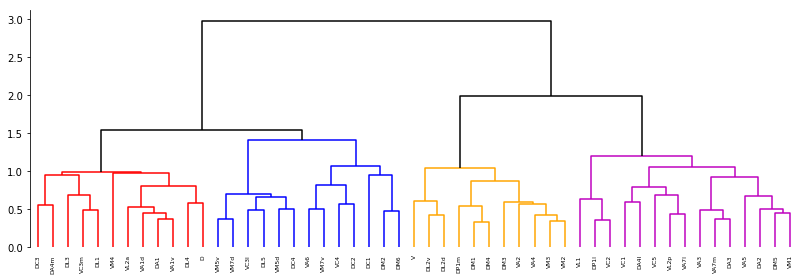

In [12]:
# Cluster using Ward's
nblast_clust.cluster(method='ward')

from scipy.cluster import hierarchy

hierarchy.set_link_color_palette(['r', 'b', 'orange', 'm'])

# Plot dendrogram
fig = nblast_clust.plot_dendrogram(color_threshold=1.5)
plt.tight_layout()
fig.set_size_inches(12,4)
# plt.savefig('PN_bouton_cluster_190807.pdf')
plt.show()

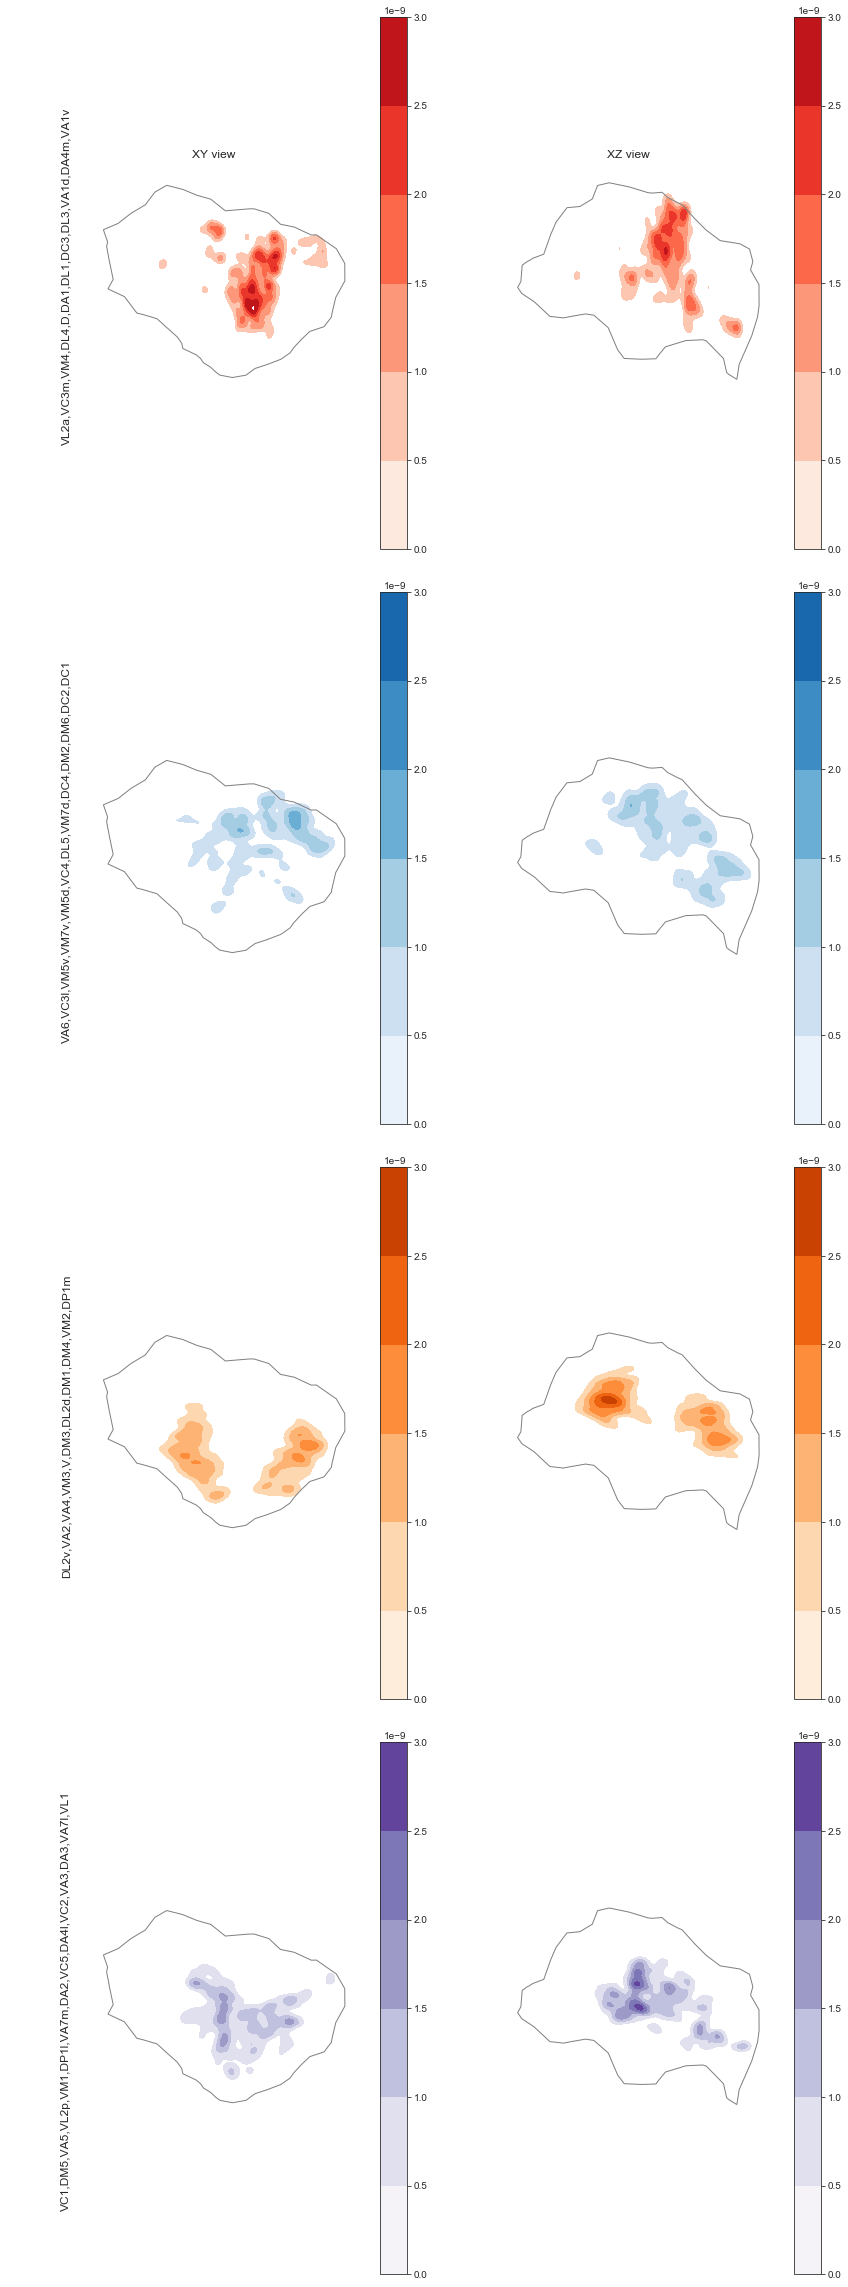

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats, cluster
import matplotlib as mpl


clust_result = nblast_clust # needs to be a pymaid.clust_results object
clust_object = super_pns_nl # needs to be a CatmaidNeuronList
cluster_names = nblast_clust.get_clusters(k=4, criterion='maxclust', return_type='labels')
cluster_skids = nblast_clust.get_clusters(k=4, criterion='maxclust', return_type='columns')

f, ax = plt.subplots(len(cluster_skids),2,figsize=(12, len(cluster_skids)*8))

sns.set_style("white")

# Palettes will repeat after 5!
poss_palettes = ['Reds','Blues','Oranges', 'Purples'] * 10

# Collect synapse positions
for i,cl in enumerate(cluster_skids):
    # Collect synapses
    this_cl = pymaid.CatmaidNeuronList( [ n for n in clust_object if n.skeleton_id in cl ] )
    this_cn = this_cl.nodes
    
    cm = mpl.cm.get_cmap(poss_palettes[i])
    
    norm = matplotlib.colors.Normalize(vmin=0, vmax=3.5e-9) 
    # create a scalarmappable from the colormap
    sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
    sm.set_array([]) 
    
    ls = np.linspace(0, 3e-9, 7)

    # Draw XY density plots (make sure to invert Y coordinates!)
    _ax1 = sns.kdeplot(this_cn.x.values, this_cn.y.values*-1,
                 cmap=cm, shade=True, shade_lowest=False, ax=ax[i][0], vmin=0, vmax=3.5e-9, levels=ls, cbar=True)
#    plt.colorbar(m, boundaries=np.linspace(0, 2.5e-9, 6), ax=_ax1)
#    plt.colorbar()
    
    # Draw XZ density plots
    _ax2 = sns.kdeplot(this_cn.x.values, this_cn.z.values,
                 cmap=cm, shade=True, shade_lowest=False, ax=ax[i][1], vmax=3.5e-9, cbar=True, levels=ls)
    
 #   plt.colorbar(m, boundaries=np.linspace(0, 2.5e-9, 6), ax=_ax2)
    
    ax[i][0].set_aspect("equal")
    ax[i][1].set_aspect("equal")

    ax[i][0].set_ylabel( ','.join(cluster_names[i]) )

    ax[i][0].text( 375000, -140000, ','.join(cluster_names[i]),  fontsize=12,
             rotation=90, verticalalignment='center', horizontalalignment='center')

    ax[i][0].set_axis_off()
    ax[i][1].set_axis_off()

    ax[i][0].set_xlim((375000, 480000))
    ax[i][0].set_ylim((-185000, -100000))

    ax[i][1].set_xlim((375000, 480000))
    ax[i][1].set_ylim((150000, 235000))

    # Draw MB calyx outlines (invert y coordinates)
    vpatch_xy = mpatches.Polygon(ca.to_2d(view='xy', invert_y=True), closed=True, lw=1, fill=False, ec='grey', alpha=1)
    ax[i][0].add_patch(vpatch_xy)

    vpatch_xz = mpatches.Polygon(ca.to_2d(view='xz', invert_y=True), closed=True, lw=1, fill=False, ec='grey', alpha=1)
    ax[i][1].add_patch(vpatch_xz)

ax[0][0].set_title('XY view')
ax[0][1].set_title('XZ view')

plt.tight_layout()
# plt.savefig('KDE_PN_bouton_4clusters_18070_v1.pdf')
# plt.savefig('KDE_PN_bouton_4clusters_w_cbar_190808_v3_wColorBar.pdf')
# plt.savefig('KDE_PN_bouton_4clusters_w_cbar_190809_wColorBar_resampled.pdf')
plt.show()

In [111]:
 df_lookup('id', comm_ids, 'glom', glom_id_table)

['DM2', 'DP1m', 'VM2', 'DL2v', 'DM3', 'DM4', 'DM1', 'VM3', 'VA2', 'VA4']

In [22]:
import matplotlib
matplotlib.__version__

'3.0.3'